## Bayesian hierarchical model to estimate treatment effects

Here, I attempt to account for the simultaneous impact of sensor feedback on lift rates and safety by:

* Modelling intervention lift rates as a function of baseline lift rates + individual fixed effects + impact from treatment group
* Combining actual baseline lift rates, predicted intervention lift rates and using them to predict safety scores, accounting for individual fixed effects


In [1]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp

In [2]:
melted_df = pd.read_csv("melted_data.csv")
df = pd.read_csv("data.csv")


In [3]:
full_obs = df.copy().dropna()

#lift rates
int_lift_rates = full_obs['Intervention Average Lift Rate'].values.reshape(-1, 1)
base_lift_rates = full_obs['Baseline Average Lift Rate'].values.reshape(-1, 1)

#scores
int_scores = full_obs['Intervention Average Safety Score'].values.reshape(-1, 1)
base_scores = full_obs['Baseline Average Safety Score'].values.reshape(-1, 1)

#treatments
int_treatments = pd.get_dummies(full_obs['Haptic Group'])
tr_names = int_treatments.columns
treatments = int_treatments.values
tr_names

Index(['2 bends in 10 minutes', '2 bends in 5 minutes',
       '3 bends in 8 minutes'],
      dtype='object')

In [9]:
with pm.Model() as m:
    
    #register the data
    scores = pm.Data("scores", int_scores)
    
    b_rates = pm.Data("baseline_rates", base_lift_rates)
    i_rates = pm.Data("intervention_rates", int_lift_rates)
    
    treats = pm.Data("treatments", treatments)    
    
    #priors
    α = pm.Normal("lift_alpha", 0, sigma=10)
    lift_treatment = pm.Normal("lift_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))    
    ind_effects = pm.Normal("lift_fixed", 0, sigma=10, shape=(base_lift_rates.shape[0], 1))
    g = pm.Normal("lift_beta", 0, sigma=10)
      
    #obtain impact of treatment to lift scores    
    pred_lift_rates = α + g*b_rates + ind_effects + pm.math.dot(treats, lift_treatment)
    
    #estimate intervention lift rates
    residual_var = pm.HalfCauchy("lift_error", beta=3)
    est_int_rates = pm.Normal('lift_int', mu=pred_lift_rates, sigma = residual_var, observed = i_rates)
    
    #priors
    alpha = pm.Normal("score_alpha", 0, sigma=50)
    lift_beta = pm.Normal("score_lift", 0, sigma=10)
    treatment_betas = pm.Normal("score_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))
    fixed_effects = pm.Normal("score_fixed", 0, sigma=10, shape=(base_lift_rates.shape[0], 1))
    
    #calculate score    
    s = alpha + (lift_beta * est_int_rates) + fixed_effects + pm.math.dot(treats, treatment_betas)
    
    #likelihood
    error_var = pm.HalfCauchy("score_error", beta=5)
    pm.Normal('likelihood', mu = s, sigma = error_var, observed = scores)    
    
    #add ANOVA tests
    zero_to_one = pm.math.ge(treatment_betas[0], treatment_betas[1])
    zero_to_two = pm.math.ge(treatment_betas[0], treatment_betas[2])
    one_to_two = pm.math.ge(treatment_betas[1], treatment_betas[2])
    
    zero_best = zero_to_one * zero_to_two
    one_best = ~zero_to_one * one_to_two
    two_best = ~zero_to_two * ~one_to_two
    pm.Deterministic("treatment_0_best", zero_best)
    pm.Deterministic("treatment_1_best", one_best)
    pm.Deterministic("treatment_2_best", two_best)
    

/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


In [10]:
with m:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lift_alpha, lift_treatment, lift_fixed, lift_beta, lift_error, score_alpha, score_lift, score_treatment, score_fixed, score_error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
There were 999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4618, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
vrs_int = ['lift_alpha', 'lift_beta', 'lift_treatment', 'score_treatment', 'lift_error', 'score_error', 'treatment_0_best', 'treatment_1_best', 'treatment_2_best', 'score_lift']
results = az.summary(trace, hdi_prob=0.90, var_names=vrs_int)
results

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lift_alpha,10.415,5.846,-1.735,18.913,0.792,0.578,58.0,24.0,1.21
lift_beta,0.763,0.047,0.697,0.861,0.006,0.005,72.0,20.0,1.38
"lift_treatment[0, 0]",7.589,4.965,-1.724,13.336,1.106,0.794,21.0,952.0,1.13
"lift_treatment[1, 0]",3.274,5.039,-5.114,10.883,1.060,0.759,22.0,442.0,1.14
"lift_treatment[2, 0]",5.812,5.287,-3.186,12.724,1.406,1.015,14.0,286.0,1.20
"score_treatment[0, 0]",4.465,6.904,-4.959,13.856,2.470,2.094,8.0,26.0,1.43
"score_treatment[1, 0]",2.923,6.143,-6.166,10.525,1.915,1.394,10.0,195.0,1.31
"score_treatment[2, 0]",2.983,6.881,-7.851,12.003,2.378,1.761,9.0,35.0,1.40
lift_error,17.365,1.132,15.689,18.987,0.347,0.255,12.0,495.0,1.24
score_error,1.336,0.445,0.685,1.923,0.172,0.127,7.0,11.0,1.65


array([[<AxesSubplot:title={'center':'lift_alpha'}>,
        <AxesSubplot:title={'center':'lift_alpha'}>],
       [<AxesSubplot:title={'center':'lift_treatment'}>,
        <AxesSubplot:title={'center':'lift_treatment'}>],
       [<AxesSubplot:title={'center':'score_treatment'}>,
        <AxesSubplot:title={'center':'score_treatment'}>],
       [<AxesSubplot:title={'center':'lift_error'}>,
        <AxesSubplot:title={'center':'lift_error'}>],
       [<AxesSubplot:title={'center':'score_error'}>,
        <AxesSubplot:title={'center':'score_error'}>],
       [<AxesSubplot:title={'center':'score_lift'}>,
        <AxesSubplot:title={'center':'score_lift'}>]], dtype=object)

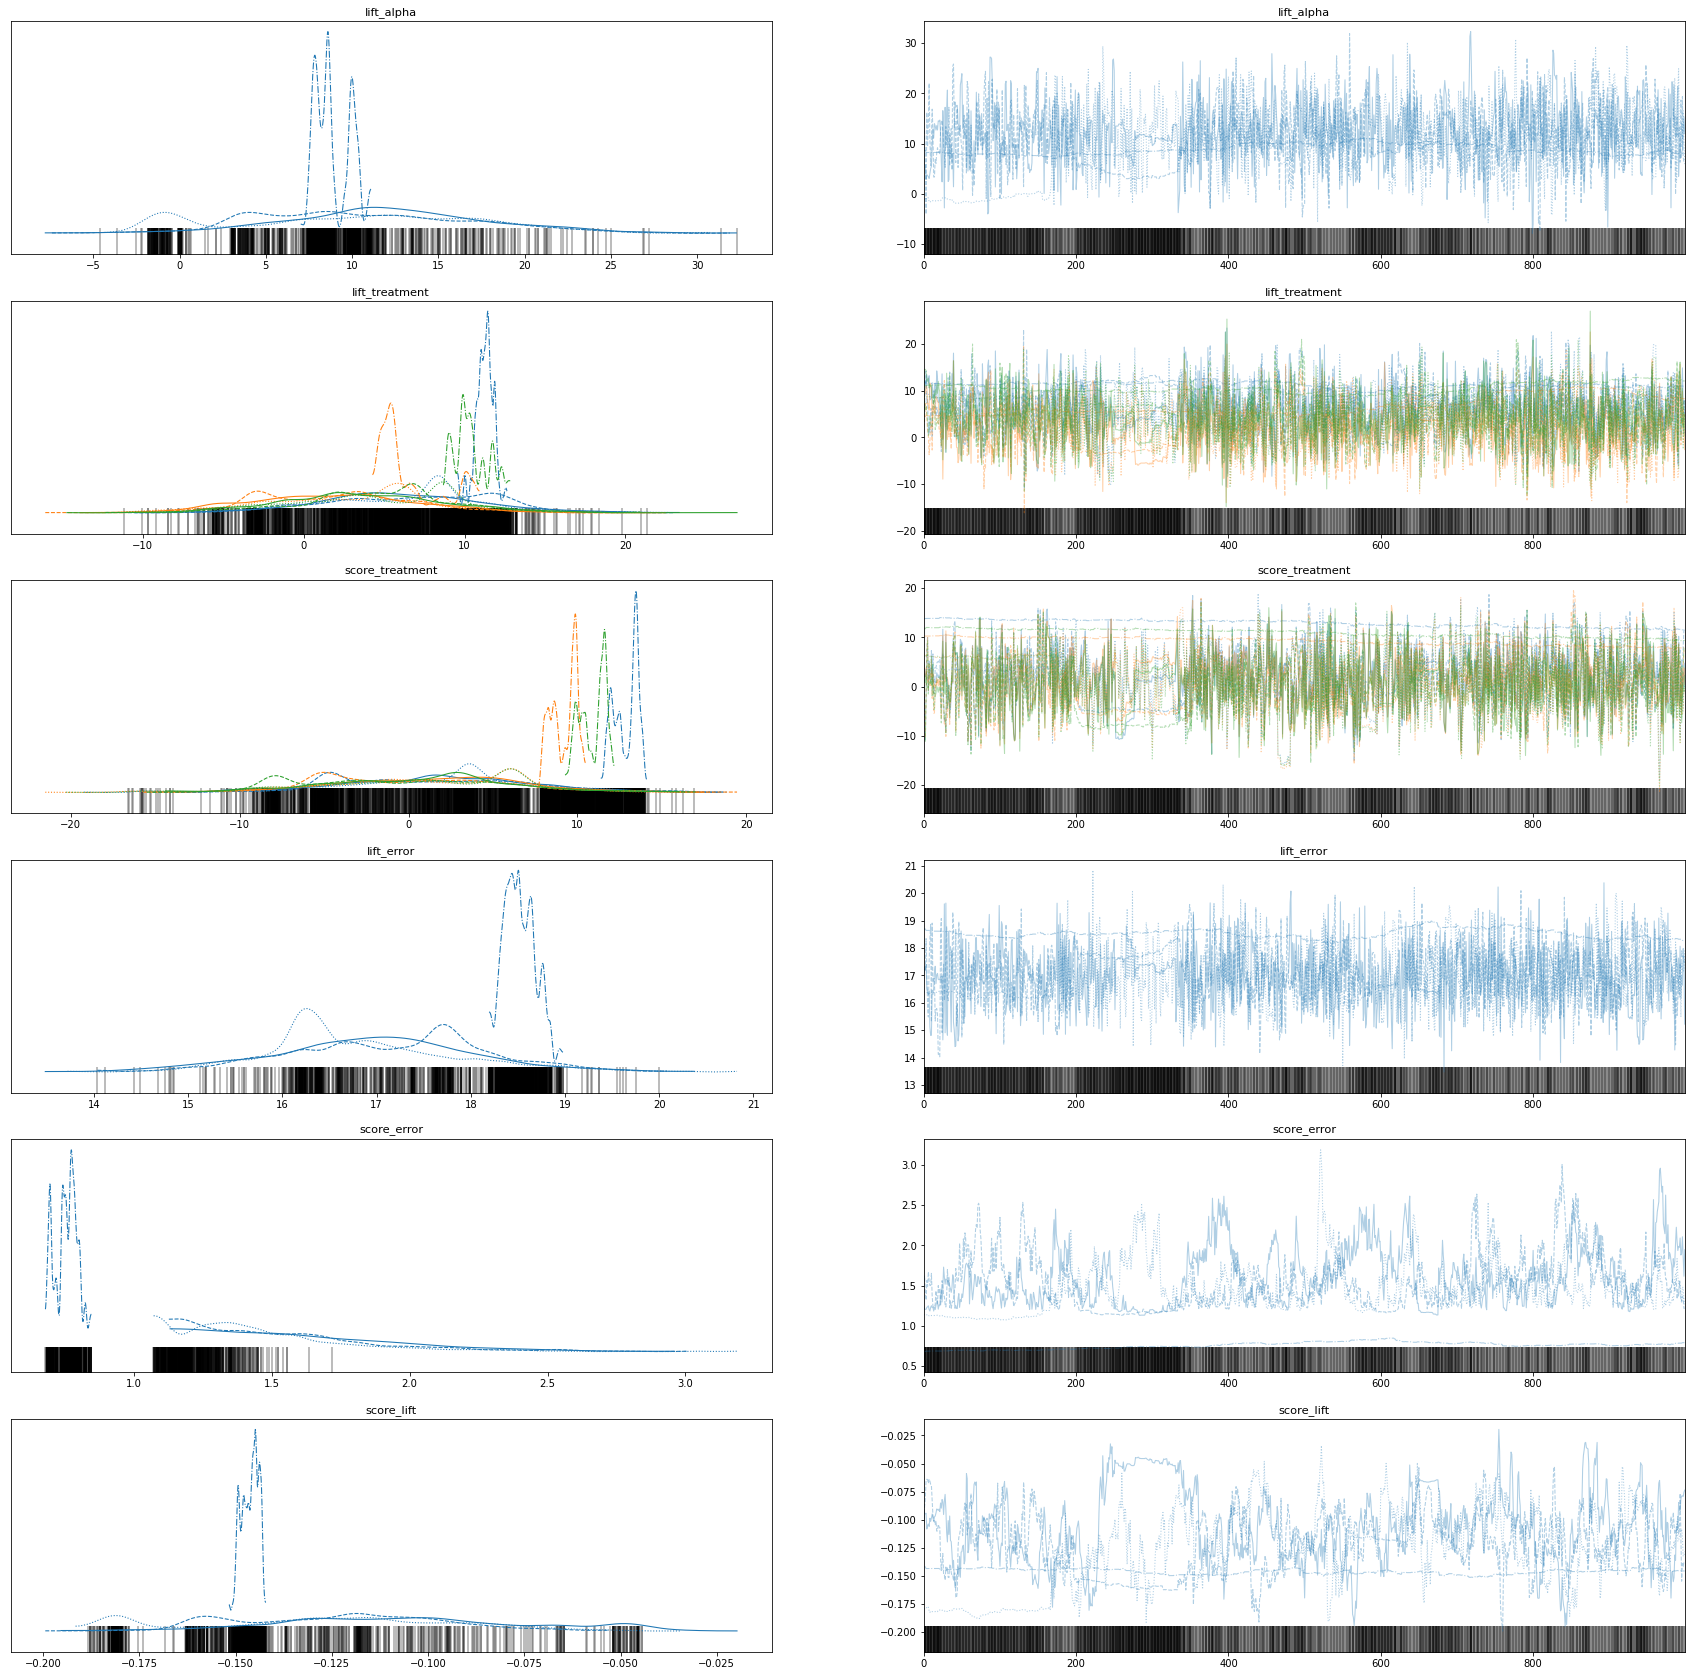

In [12]:
az.plot_trace(trace, figsize=(30,30), var_names=['lift_alpha', 'lift_treatment', 'score_treatment', 'lift_error', 'score_error', 'score_lift'])